In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pd.set_option('display.max_columns', 30)

### Data

In [5]:
df = pd.read_csv('../../DATA/HSC-unWISE-W01.csv')
# df2 = pd.read_csv('../DATA/HSC-unWISE-W02.csv')
# df = pd.concat([df1,df2], axis = 'rows')
# del df1,df2

with open('../../DATA/all_features.txt') as file:
    features = file.read().splitlines()
labels = 'member'

n_mem = df[df.member == 1].shape[0]
n_no = df[df.member == 0].shape[0]
n = df.shape[0]
print ('Members: {} ({:.2f}%)'.format(n_mem, n_mem/n*100))
print ('Non members: {} ({:.2f}%)'.format(n_no, n_no/n*100))
del n,n_mem,n_no

Members: 7581 (35.55%)
Non members: 13743 (64.45%)


In [ ]:
# # Undersample majority class
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(sampling_strategy= 4./6., replacement= False)
# rus_feat, rus_lab = rus.fit_resample(df[features], df[labels])
# rus_feat[labels] = rus_lab

# df = rus_feat
# del rus, rus_feat, rus_lab

# n_mem = df[df.member == 1].shape[0]
# n_no = df[df.member == 0].shape[0]
# n = df.shape[0]
# print ('Members: {} ({:.2f}%)'.format(n_mem, n_mem/n*100))
# print ('Non members: {} ({:.2f}%)'.format(n_no, n_no/n*100))
# del n,n_mem,n_no

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.35, stratify = df[labels], random_state= 42)
print ('Training: {} members, {} non members'.format(train[train.member == 1].shape[0], train[train.member == 0].shape[0] ))
print ('Testing: {} members, {} non members'.format(test[test.member == 1].shape[0], test[test.member == 0].shape[0]))

Training: 4927 members, 8933 non members
Testing: 2654 members, 4810 non members


### Model & Searches

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(bootstrap= True, n_jobs = -1, verbose= 0, class_weight= 'balanced')

# params = dict(
#     n_estimators = [20,50,80,100,120],
#     criterion = ['gini', 'entropy', 'log_loss'],
#     max_depth = [None, 10, 20, 30],
#     min_samples_split = [2, 5, 10, 15],
#     min_samples_leaf = [1, 2, 4, 10],
#     max_features = ['sqrt', 'log2', None]
#     # max_leaf_nodes = [None, 50, 20],
#     # min_impurity_decrease = [0.0, 0.1, 0.01, 0.001, 0.0001],
#     # max_samples = [None, 0.5, 0.25, 0.75]
# )

# from sklearn.model_selection import RandomizedSearchCV

# rs = RandomizedSearchCV(estimator= model, param_distributions= params, cv= 3, n_jobs= -1,  verbose= 4, n_iter = 100)
# rs.fit(train[features], train[labels])

# df_rs = pd.DataFrame(rs.cv_results_)

In [7]:
model_params =  {
    "n_estimators" : 120,
    "criterion" : "entropy",
    "max_depth" : 30,
    "min_samples_split" : 2, 
    "min_samples_leaf" : 1,
    "max_features" : "log2"
}


from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(bootstrap= True, n_jobs = -1, verbose= 0, class_weight= 'balanced',
                               **model_params)

model.fit(train[features], train[labels])

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features='log2', n_estimators=120,
                       n_jobs=-1)

### Tests


In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report

pred = model.predict(test[features])
scores = model.predict_proba(test[features])
model_score = model.score(test[features], test[labels])

fpr, tpr, thresholds_roc = roc_curve(test[labels], scores[:,1], pos_label=1)
precision, recall, thresholds_pr = precision_recall_curve(test[labels], scores[:,1], pos_label= 1)

print(f'Model score: {model_score}')
print('ROC AUC: {}'.format(auc(fpr, tpr)))
print('Precision-recall AUC: {}'.format(auc(recall, precision)))
print('-'*70)
print(classification_report(test[labels],pred))

Model score: 0.6907824222936764
ROC AUC: 0.7152643716697974
Precision-recall AUC: 0.5759941150559579
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      4810
           1       0.60      0.40      0.48      2654

    accuracy                           0.69      7464
   macro avg       0.66      0.63      0.63      7464
weighted avg       0.68      0.69      0.67      7464



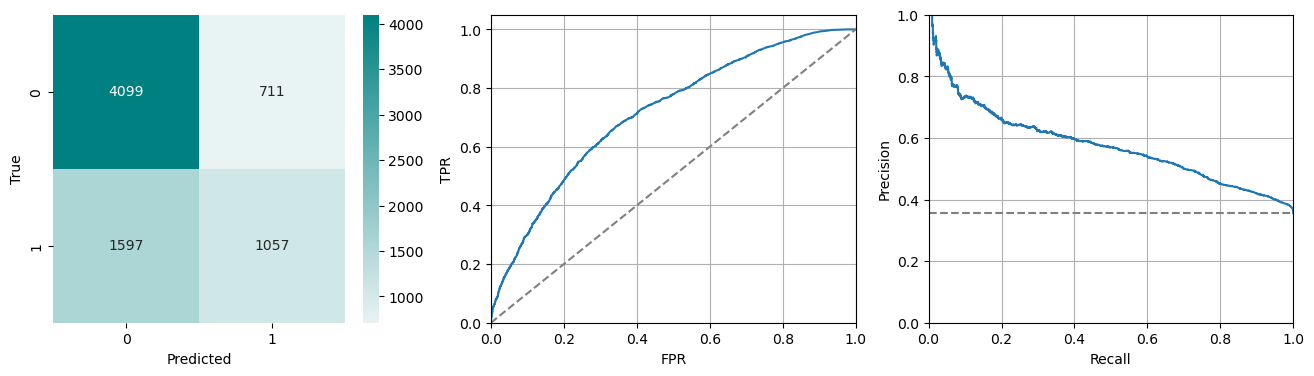

In [9]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(16,4))

# Confusion matrix
plt.subplot(1, 3, 1)
conf_m = confusion_matrix(test[labels], pred)
df_conf_m = pd.DataFrame(conf_m, index=[0,1], columns=[0,1])
sns.heatmap(df_conf_m, cmap=sns.color_palette('light:teal', as_cmap=True), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

# ROC Curve
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

# Precision-recall curve
plt.subplot(1, 3, 3)
plt.plot(recall, precision)
plt.plot([0, 1], [len (test[test.member == 1])/len(test), len (test[test.member == 1])/len(test)] , color='gray', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0,1])
plt.ylim([0,1])

plt.show()

<AxesSubplot: >

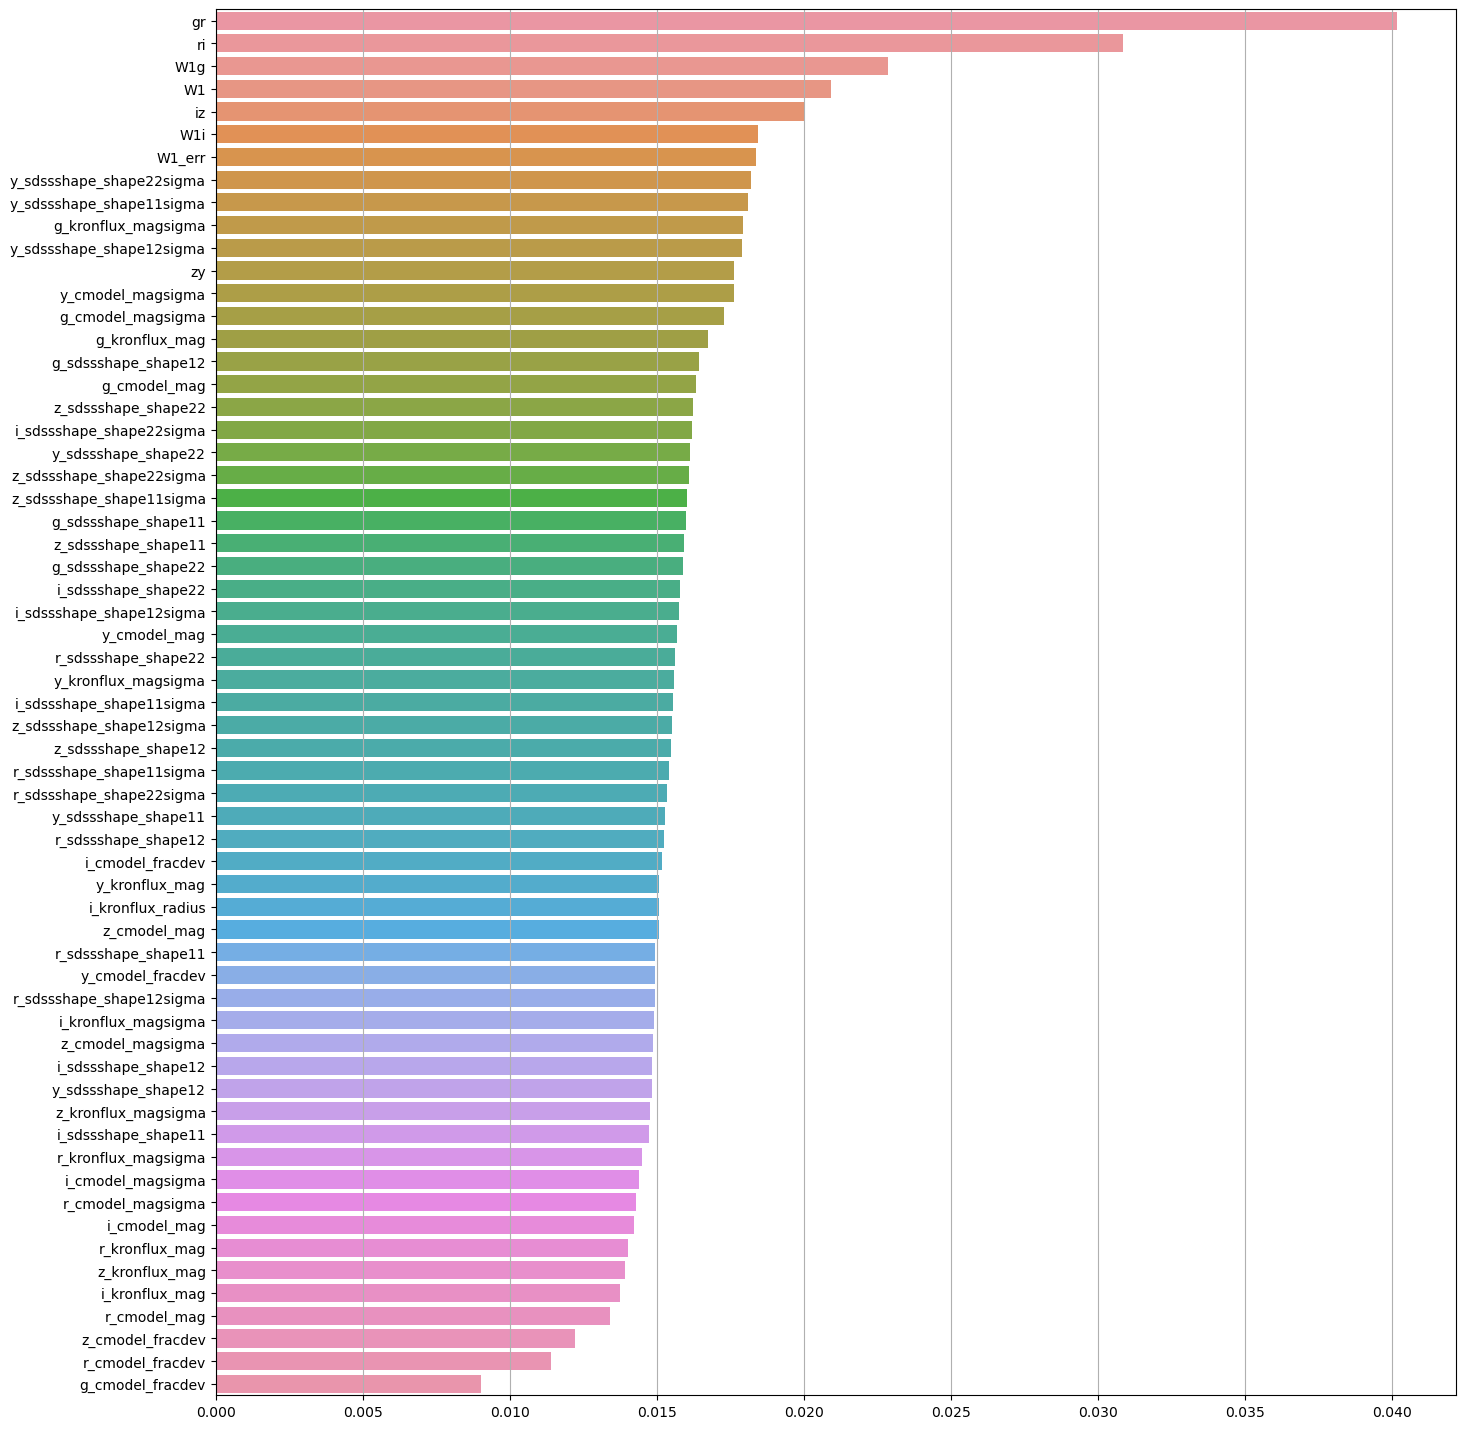

In [42]:
importances = np.sort(model.feature_importances_)[::-1]
sorted_features = [x for _,x in sorted(zip(model.feature_importances_, features))][::-1]

plt.figure(figsize= (16, 18))
plt.grid()
sns.barplot(x = importances, y = sorted_features)

<AxesSubplot: >

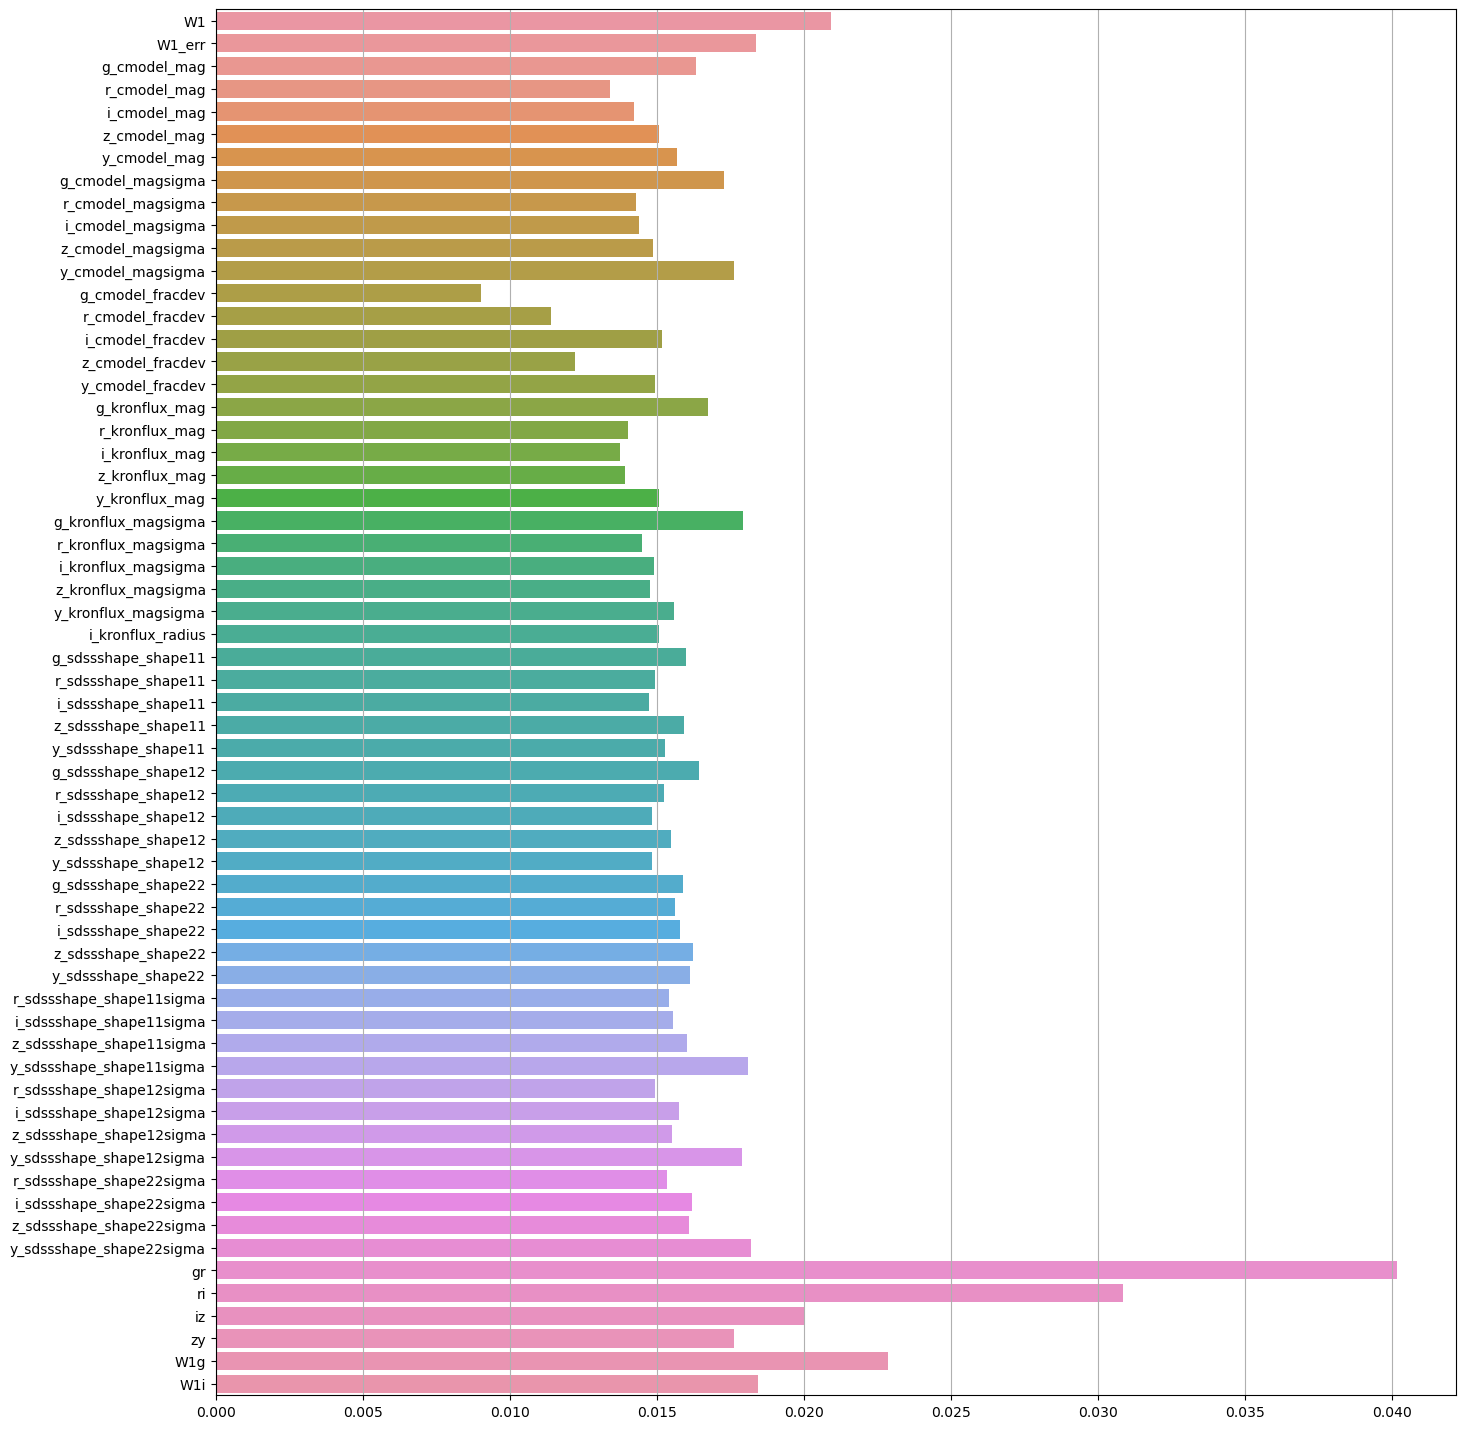

In [43]:
plt.figure(figsize= (16, 18))
plt.grid()
sns.barplot(x = model.feature_importances_, y = features)